In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from features.extractor import FeatureExtractor
from tuning.optuna_tuning import OptunaTuner
from configs import utils

from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
import optuna
import wandb

/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

In [2]:
try:
    customers, sales = joblib.load('customers.joblib'), joblib.load('sales.joblib')
except:
    customers, sales = pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_customers'), pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_sales')
    joblib.dump(customers, 'customers.joblib')
    joblib.dump(sales, 'sales.joblib')

In [3]:
fe = FeatureExtractor(sales=sales, customers=customers, target_month=3, perform_split=False, generation_type='categorical', filtering_set='sales', period=60, subperiod=15)
X, y = fe.transform()
X.dtypes

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/fedorturchenko/.cache/huggingface/token
Login successful
Successfully logged out.


prodcatbroad_1-15               category
prodcatbroad_16-30              category
prodcatbroad_31-45              category
prodcatbroad_46-60              category
peak_hour_1-15                  category
peak_hour_16-30                 category
peak_hour_31-45                 category
peak_hour_46-60                 category
weekday_1-15                    category
weekday_16-30                   category
weekday_31-45                   category
weekday_46-60                   category
fuel_type_1-15                  category
fuel_type_16-30                 category
fuel_type_31-45                 category
fuel_type_46-60                 category
last_purchase_share_1-15         float32
last_purchase_share_16-30        float32
last_purchase_share_31-45        float32
last_purchase_share_46-60        float32
full_non_fuel_purchase_1-15     category
full_non_fuel_purchase_16-30    category
full_non_fuel_purchase_31-45    category
full_non_fuel_purchase_46-60    category
segments        

In [4]:
X_train, X_test, y_train, y_test = fe.perform_train_test_split(X, y)

## Default Parameters Performance

In [5]:
cat = CatBoostClassifier(cat_features=[col for col in X_train.columns if 'last_purchase_share' not in col], random_seed=571)

In [6]:
cat.fit(X_train, y_train)
train_preds = cat.predict(X_train)
test_preds = cat.predict(X_test)

Learning rate set to 0.057211
0:	learn: 0.6667778	total: 105ms	remaining: 1m 44s
1:	learn: 0.6438352	total: 151ms	remaining: 1m 15s
2:	learn: 0.6232545	total: 189ms	remaining: 1m 2s
3:	learn: 0.6055267	total: 240ms	remaining: 59.7s
4:	learn: 0.5900876	total: 302ms	remaining: 1m
5:	learn: 0.5771433	total: 349ms	remaining: 57.8s
6:	learn: 0.5652399	total: 402ms	remaining: 57s
7:	learn: 0.5556213	total: 463ms	remaining: 57.5s
8:	learn: 0.5467303	total: 507ms	remaining: 55.8s
9:	learn: 0.5391370	total: 558ms	remaining: 55.2s
10:	learn: 0.5324739	total: 610ms	remaining: 54.8s
11:	learn: 0.5267068	total: 663ms	remaining: 54.5s
12:	learn: 0.5214045	total: 719ms	remaining: 54.6s
13:	learn: 0.5171008	total: 768ms	remaining: 54.1s
14:	learn: 0.5130786	total: 814ms	remaining: 53.4s
15:	learn: 0.5095021	total: 868ms	remaining: 53.4s
16:	learn: 0.5066908	total: 914ms	remaining: 52.8s
17:	learn: 0.5041241	total: 955ms	remaining: 52.1s
18:	learn: 0.5017778	total: 1.01s	remaining: 52s
19:	learn: 0.499

In [7]:
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.75      0.78      0.77     25669
           1       0.81      0.78      0.79     29752

    accuracy                           0.78     55421
   macro avg       0.78      0.78      0.78     55421
weighted avg       0.78      0.78      0.78     55421



In [8]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      8603
           1       0.80      0.77      0.79      9871

    accuracy                           0.78     18474
   macro avg       0.78      0.78      0.78     18474
weighted avg       0.78      0.78      0.78     18474



<BarContainer object of 25 artists>

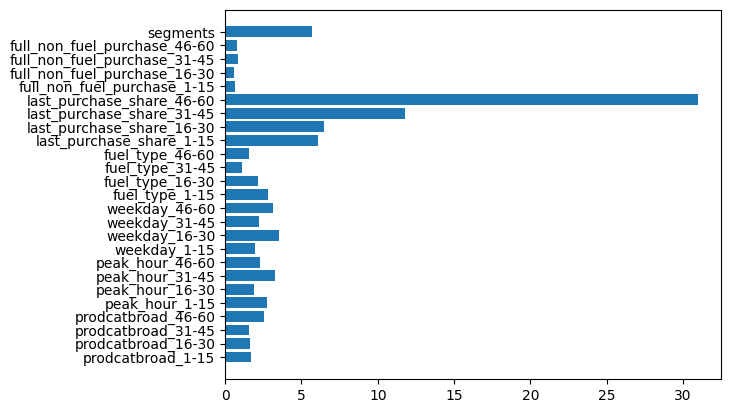

In [9]:
importances = cat.feature_importances_
names = cat.feature_names_
plt.barh(names, importances)

## Parameters tuning

In [10]:
cb_op = OptunaTuner(
    CatBoostClassifier,
    accuracy_score,
    direction='maximize',
    random_state=571,
    verbose=0,
    cat_features=[col for col in X_train.columns if 'last_purchase_share' not in col]
)
cb_op.fit(
    100, X_train, y_train, X_test, y_test,
    ('learning_rate', 'float', 1e-3, 1e-1, {'log': True}),
    ('depth', 'int', 2, 11),
    ('iterations', 'int', 100, 1000),
    ('subsample', 'float', 0.05, 1.0),
    ('colsample_bylevel', 'float', 0.05, 1.0),
    ('min_data_in_leaf', 'int', 1, 100),
)

In [ ]:
optuna.visualization.plot_optimization_history(cb_op.study)

In [ ]:
config = cb_op.model.get_params()
cat = CatBoostClassifier(**config)

# Create w&b run for the training set
with utils.init_wandb_run(
    name=f'categorical_features_optuna_subperiod_{fe.subperiod}',
    model=CatBoostClassifier,
    config=config,
    target_month=fe.target_month,
    group='parameters_tuning',
    job_type='tuning_train'
) as run:

    cat.fit(X_train, y_train)
    train_preds = cat.predict(X_train)

    rep = utils.parse_classification_report(
        classification_report(y_train, train_preds, output_dict=True)
    )

    metadata = {
        'experiment': {
            'name': run.name,
        },
        'performance_report': rep,
        'config': config
    }

    artifact = wandb.Artifact(
        name=f'report_train',
        type='performance_metric',
        metadata=metadata
    )
    run.log_artifact(artifact)
    run.finish()

# Create w&b run for the test set
with utils.init_wandb_run(
    name=f'categorical_features_optuna_subperiod_{fe.subperiod}',
    model=CatBoostClassifier,
    config=config,
    target_month=fe.target_month,
    group='parameters_tuning',
    job_type='tuning_test'
) as run:
    test_preds = cat.predict(X_test)
    rep = utils.parse_classification_report(
        classification_report(y_test, test_preds, output_dict=True)
    )

    metadata = {
        'experiment': {
            'name': run.name,
        },
        'performance_report': rep,
        'config': config
    }

    artifact = wandb.Artifact(
        name=f'report_test',
        type='performance_metric',
        metadata=metadata
    )
    run.log_artifact(artifact)
    run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
